In [1]:
import pandas as pd
import jieba
import re
import matplotlib
import matplotlib.pyplot as plt
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models
import numpy as np

from pymongo import MongoClient
import pymongo

In [2]:
# 使用GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
! nvidia-smi

Thu Jun 23 15:40:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.129.06   Driver Version: 470.129.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 48%   60C    P2    85W / 260W |   3044MiB / 11019MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 29%   

# LDA

## 2017 brief paragraph

In [3]:
file_cn = open("../LDA/segment/data/cn_file_brief_paragraph_2017.txt", "r")
cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_brief_p_paragraph.txt", "r")
# us_lines = file_us.readlines()

In [4]:
cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [5]:
id2word = corpora.Dictionary(cn_desc)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(17643 unique tokens: ['一种', '之上', '之间', '传感器', '传送']...)


In [6]:
corpus = [id2word.doc2bow(text) for text in cn_desc]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 2), (3, 2), (4, 1), (5, 1), (6, 3), (7, 1), (8, 3), (9, 1)]


+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [7]:
topic_num_list = np.arange(2, 26, 1)
result = []
for topic_num in topic_num_list:
    # perplexity
    tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )
    tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
    temp_skleran = np.exp(-1. * tmp_perplexity)
    
    result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
    print(topic_num)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


,topic_num,gensim_perplexity,perplexity
0,2,-7.120781,1237.416129
1,3,-7.111014,1225.389861
2,4,-7.074088,1180.965393
3,5,-7.073244,1179.969456
4,6,-7.051481,1154.567074
5,7,-7.018642,1117.267857
6,8,-7.012502,1110.428819
7,9,-7.002706,1099.604223
8,10,-7.000482,1097.162131
9,11,-7.001584,1098.371142


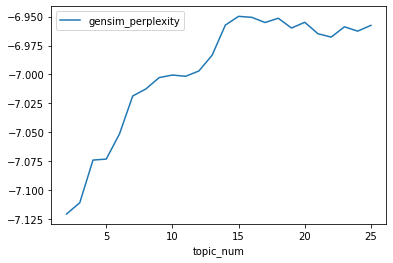

In [8]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
result

,topic_num,gensim_perplexity,perplexity
0,2,-7.120781,1237.416129
1,3,-7.111014,1225.389861
2,4,-7.074088,1180.965393
3,5,-7.073244,1179.969456
4,6,-7.051481,1154.567074
5,7,-7.018642,1117.267857
6,8,-7.012502,1110.428819
7,9,-7.002706,1099.604223
8,10,-7.000482,1097.162131
9,11,-7.001584,1098.371142


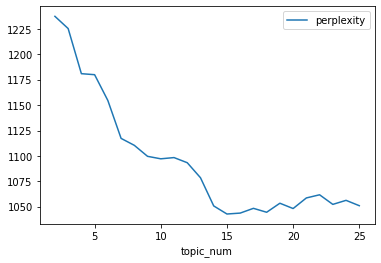

In [9]:
result = pd.DataFrame(result)
result.plot.line(x='topic_num', y='perplexity', label='perplexity')
result

In [10]:
# 儲存LDA_result
result.to_csv("./result/LDA_cn_brief_paragraph_2017.csv", index=False)

## priority description sentence

In [11]:
# file_cn = open("../MUSE-main/data/cn_file_desc_p_s_2500.txt", "r")
# cn_lines = file_cn.readlines()

# file_us = open("../MUSE-main/data/us_file_desc_p_s_2500.txt", "r")
# us_lines = file_us.readlines()

In [12]:
# cn_desc = [i.replace(" \n","").split(" ") for i in cn_lines]
# us_desc = [i.replace(" \n","").split(" ") for i in us_lines]

In [13]:
# id2word = corpora.Dictionary(cn_desc)
# print('資料集字典：')
# print(id2word)

In [14]:
# corpus = [id2word.doc2bow(text) for text in cn_desc]
# print('第一篇文章 corpus :')
# print(corpus[0][:10])

+ corpus = 文檔語料庫
+ id2word = 詞彙字典
+ num_topics = 生成幾個主題數
+ random_state = 固定亂數值，每次的模型結果會一樣
+ iteration = 每個文章訓練的次數，可以設定高一點讓模型收斂
+ passes(epoch) = 整個 corpus 訓練模型的次數
+ alpha = 文章主題分佈
+ eta = 主題字分佈

In [15]:
# topic_num_list = np.arange(2, 20, 2)
# result = []
# for topic_num in topic_num_list:
#     # perplexity
#     tmp_ldamodel = gensim.models.ldamulticore.LdaMulticore(
#         corpus = corpus,
#         num_topics = topic_num ,
#         id2word=id2word,
#         random_state = 1500,
#         passes=5,
#         iterations=2000
#         )
#     tmp_perplexity = tmp_ldamodel.log_perplexity(corpus)
#     temp_skleran = np.exp(-1. * tmp_perplexity)
    
#     result.append({"topic_num": topic_num, "gensim_perplexity": tmp_perplexity, "perplexity":temp_skleran})
#     print(topic_num)

In [16]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='gensim_perplexity', label='gensim_perplexity')
# result

In [17]:
# result = pd.DataFrame(result)
# result.plot.line(x='topic_num', y='perplexity', label='perplexity')
# result

In [18]:
# 儲存LDA_result
# result.to_csv("./result/LDA_cn_desc_p_s_2500.csv", index=False)

## 找出文章topic

In [19]:
best_num = result[result.perplexity == min(result.perplexity)]["topic_num"].values[0]

In [20]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
        corpus = corpus,
        num_topics = best_num ,
        id2word=id2word,
        random_state = 1500,
        passes=5,
        iterations=2000
        )

In [21]:
# 取得每個文章的主題分佈
topics_doc = ldamodel.get_document_topics(corpus, minimum_probability=0.000001) 

In [22]:
c = [i[1] for i in topics_doc[0]]
c.index(max(c)) 

1

In [23]:
topics_cn = [] 
for topics in topics_doc:
    c = [i[1] for i in topics]
    topics_cn.append(c.index(max(c)))

In [24]:
topics_cn

[1,
 13,
 11,
 11,
 13,
 1,
 1,
 11,
 14,
 14,
 5,
 2,
 1,
 11,
 1,
 1,
 11,
 13,
 2,
 1,
 5,
 5,
 11,
 11,
 1,
 5,
 14,
 1,
 4,
 5,
 1,
 11,
 5,
 7,
 1,
 1,
 8,
 4,
 4,
 11,
 11,
 4,
 1,
 11,
 4,
 1,
 4,
 1,
 5,
 1,
 1,
 4,
 1,
 1,
 4,
 11,
 4,
 3,
 3,
 5,
 8,
 11,
 11,
 14,
 13,
 1,
 10,
 1,
 14,
 14,
 2,
 13,
 5,
 4,
 14,
 5,
 1,
 4,
 11,
 1,
 14,
 12,
 11,
 5,
 13,
 4,
 13,
 13,
 13,
 8,
 12,
 13,
 13,
 14,
 11,
 1,
 7,
 4,
 5,
 4,
 4,
 13,
 1,
 11,
 8,
 10,
 11,
 14,
 11,
 4,
 5,
 4,
 1,
 13,
 14,
 13,
 1,
 1,
 7,
 4,
 8,
 1,
 3,
 14,
 7,
 1,
 14,
 8,
 11,
 10,
 14,
 7,
 1,
 8,
 1,
 5,
 5,
 11,
 2,
 13,
 1,
 13,
 1,
 1,
 12,
 4,
 13,
 13,
 1,
 13,
 7,
 14,
 14,
 8,
 1,
 13,
 14,
 11,
 14,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 11,
 12,
 13,
 13,
 13,
 14,
 8,
 13,
 4,
 6,
 13,
 11,
 5,
 4,
 4,
 1,
 12,
 7,
 4,
 5,
 6,
 1,
 13,
 13,
 13,
 1,
 13,
 14,
 12,
 13,
 8,
 4,
 13,
 11,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 14,
 11,
 13,
 13,
 11,
 14,
 14,
 13,
 13,
 13,
 13,
 13,
 1

In [25]:
print(len(topics_cn))
print(len(cn_desc))

6557
6557


## 找出對應的patent編號和公司

In [26]:
mongoURI = "mongodb://%s:%s@%s/%s?authMechanism=SCRAM-SHA-1" % ("eva", "eva_30241", "140.117.69.70:30241", "eva")

try:
    conn = pymongo.MongoClient(mongoURI)
    db = conn.eva
    # db_rm_us = db.rm_patent_us
    # db_rm_cn = db.rm_patent_cn
    # db_rm_de = db.rm_patent_de
    
    # db_rm_us_2017 = db.rm_patent_us_2017
    db_rm_cn_2017 = db.rm_patent_cn_2017
    # db_rm_de_2017 = db.rm_patent_de_2017
except errors.ConnectionFailure as err:
    print(err)

In [27]:
# data_cn_desc = p_db_cn.find({}, {"patentNumber":1, "brief": 1})
data_cn_desc = db_rm_cn_2017.find({}, {"patentNumber":1, "brief": 1, "current_assignee":1})

ls_id = []
ls_pNo = []
ls_com = []
ls_desc = []
for data in data_cn_desc:
    # print(data["_id"],data["count"])
    ls_id.append(data["_id"])
    ls_pNo.append(data["patentNumber"])
    ls_com.append(data["current_assignee"])
    ls_desc.append(data["brief"])
    

In [28]:
# df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_desc)), columns = ['id', 'patentNumber', 'brief'])
df_cn = pd.DataFrame((zip(ls_id, ls_pNo, ls_com, ls_desc)), columns = ['id', 'patentNumber', 'company', 'brief'])

In [29]:
df_cn

,id,patentNumber,company,brief
0,61fe6eb8f4d57576a5024e4b,CN107038960A,[],本发明公开了一种微显示器系统，包括衬底和位于所述衬底之上的显示层；设置在所述衬底和所述显示层...
1,61fe6ebaf4d57576a5024e4d,CN111984586A,[Shaanxi Aishanwulian Technology Co ltd],本公开实施例公开了一种机器人体系架构，包括：机器人，其为含有计算机系统的机器装置；机器人主人...
2,61fe6f13f4d57576a5024e51,CN107277443B,[Shenzhen Shenglu IoT Communication Technology...,本发明涉及一种大范围周边安全监控方法和系统，方法包括：创建入侵特征库；采集受监控区域边界的微...
3,61fe6f39f4d57576a5024e57,CN107727420B,[Shenzhen Shenglu IoT Communication Technology...,本发明实施例提供了一种设备检测方法及相关产品，所述方法包括如下步骤：获取太空设备的运行数据；...
4,61fe6f78f4d57576a5024e67,CN107438224A,[Changsha Vocational and Technical College],本发明提供了一种基于低功耗广域网LPWAN的生命体征监控系统，包括多个生命体征检测设备、网关...
...,...,...,...,...
6552,61ffe106f4d57576a502c4a5,CN207634251U,[Shanghai Zhenghua Heavy Industries Co Ltd],本实用新型公开了一种多动力发电传动汇聚系统，包括第一卷扬机构、第二卷扬机构、第三卷扬机构、第...
6553,61ffe107f4d57576a502c4a7,CN109962712B,[Chicony Electronics Co Ltd],本发明提出一种网络联机系统及网络联机方法。此方法包含以下步骤：通过第一连网装置基于无线通信协...
6554,61ffe108f4d57576a502c4a9,CN207802675U,"[Bixing IOT Technology (Shenzhen) Co.,Ltd.]",本实用新型公开了一种用于信号发射和测量的屏蔽结构，设置于信号检测单板上，包括有至少一金属屏蔽...
6555,61ffe108f4d57576a502c4ab,CN207799059U,"[Bixing IOT Technology (Shenzhen) Co.,Ltd.]",本实用新型公开了一种判断不同频段信号源位置的分层式测向天线装置，包括有两套测向天线系统，分别...


In [30]:
print(len(df_cn))
print(len(cn_desc))

6557
6557


In [31]:
df_cn["topic"]=topics_cn

In [32]:
df_cn

,id,patentNumber,company,brief,topic
0,61fe6eb8f4d57576a5024e4b,CN107038960A,[],本发明公开了一种微显示器系统，包括衬底和位于所述衬底之上的显示层；设置在所述衬底和所述显示层...,1
1,61fe6ebaf4d57576a5024e4d,CN111984586A,[Shaanxi Aishanwulian Technology Co ltd],本公开实施例公开了一种机器人体系架构，包括：机器人，其为含有计算机系统的机器装置；机器人主人...,13
2,61fe6f13f4d57576a5024e51,CN107277443B,[Shenzhen Shenglu IoT Communication Technology...,本发明涉及一种大范围周边安全监控方法和系统，方法包括：创建入侵特征库；采集受监控区域边界的微...,11
3,61fe6f39f4d57576a5024e57,CN107727420B,[Shenzhen Shenglu IoT Communication Technology...,本发明实施例提供了一种设备检测方法及相关产品，所述方法包括如下步骤：获取太空设备的运行数据；...,11
4,61fe6f78f4d57576a5024e67,CN107438224A,[Changsha Vocational and Technical College],本发明提供了一种基于低功耗广域网LPWAN的生命体征监控系统，包括多个生命体征检测设备、网关...,13
...,...,...,...,...,...
6552,61ffe106f4d57576a502c4a5,CN207634251U,[Shanghai Zhenghua Heavy Industries Co Ltd],本实用新型公开了一种多动力发电传动汇聚系统，包括第一卷扬机构、第二卷扬机构、第三卷扬机构、第...,11
6553,61ffe107f4d57576a502c4a7,CN109962712B,[Chicony Electronics Co Ltd],本发明提出一种网络联机系统及网络联机方法。此方法包含以下步骤：通过第一连网装置基于无线通信协...,12
6554,61ffe108f4d57576a502c4a9,CN207802675U,"[Bixing IOT Technology (Shenzhen) Co.,Ltd.]",本实用新型公开了一种用于信号发射和测量的屏蔽结构，设置于信号检测单板上，包括有至少一金属屏蔽...,8
6555,61ffe108f4d57576a502c4ab,CN207799059U,"[Bixing IOT Technology (Shenzhen) Co.,Ltd.]",本实用新型公开了一种判断不同频段信号源位置的分层式测向天线装置，包括有两套测向天线系统，分别...,11


In [33]:
df_cn2 = df_cn.explode('company')
df_cn2

,id,patentNumber,company,brief,topic
0,61fe6eb8f4d57576a5024e4b,CN107038960A,NaN,本发明公开了一种微显示器系统，包括衬底和位于所述衬底之上的显示层；设置在所述衬底和所述显示层...,1
1,61fe6ebaf4d57576a5024e4d,CN111984586A,Shaanxi Aishanwulian Technology Co ltd,本公开实施例公开了一种机器人体系架构，包括：机器人，其为含有计算机系统的机器装置；机器人主人...,13
2,61fe6f13f4d57576a5024e51,CN107277443B,Shenzhen Shenglu IoT Communication Technology ...,本发明涉及一种大范围周边安全监控方法和系统，方法包括：创建入侵特征库；采集受监控区域边界的微...,11
3,61fe6f39f4d57576a5024e57,CN107727420B,Shenzhen Shenglu IoT Communication Technology ...,本发明实施例提供了一种设备检测方法及相关产品，所述方法包括如下步骤：获取太空设备的运行数据；...,11
4,61fe6f78f4d57576a5024e67,CN107438224A,Changsha Vocational and Technical College,本发明提供了一种基于低功耗广域网LPWAN的生命体征监控系统，包括多个生命体征检测设备、网关...,13
...,...,...,...,...,...
6552,61ffe106f4d57576a502c4a5,CN207634251U,Shanghai Zhenghua Heavy Industries Co Ltd,本实用新型公开了一种多动力发电传动汇聚系统，包括第一卷扬机构、第二卷扬机构、第三卷扬机构、第...,11
6553,61ffe107f4d57576a502c4a7,CN109962712B,Chicony Electronics Co Ltd,本发明提出一种网络联机系统及网络联机方法。此方法包含以下步骤：通过第一连网装置基于无线通信协...,12
6554,61ffe108f4d57576a502c4a9,CN207802675U,"Bixing IOT Technology (Shenzhen) Co.,Ltd.",本实用新型公开了一种用于信号发射和测量的屏蔽结构，设置于信号检测单板上，包括有至少一金属屏蔽...,8
6555,61ffe108f4d57576a502c4ab,CN207799059U,"Bixing IOT Technology (Shenzhen) Co.,Ltd.",本实用新型公开了一种判断不同频段信号源位置的分层式测向天线装置，包括有两套测向天线系统，分别...,11


In [34]:
# 排名前16的公司
c_ls = list(df_cn2.groupby("company",as_index=False).size().sort_values("size",ascending=False).head(16).company)
c_ls

['Shenzhen Shenglu IoT Communication Technology Co Ltd',
 'Huawei Technologies Co Ltd',
 'Samsung Electronics Co Ltd',
 'Qualcomm Inc',
 'Xian Irain IoT Technology Service Co Ltd',
 'Chengdu Qinchuan IoT Technology Co Ltd',
 'Hangzhou Wopu IoT Technology Co Ltd',
 'China Mobile Communications Group Co Ltd',
 'ZTE Corp',
 'Shanghai Langbo Communication Technology Co Ltd',
 'Telefonaktiebolaget LM Ericsson AB',
 'Fujian Strong Min Mdt Infotech Ltd',
 'Huaway IoT Technology Co Ltd',
 'Intel Corp',
 'HUIZHOU TECHZEN IOT SCIENCE & TECHNOLOGY Co Ltd',
 'China Mobile Communications Ltd Research Institute']

### 轉成company-topic 的總數表格

In [35]:
df_cn_count = df_cn2.groupby(["company","topic"],as_index=False).size()
df_cn_count

,company,topic,size
0,A Iot Technology Co Ltd (the),8,1
1,ABB Grid Switzerland AG,0,1
2,ABB Schweiz AG,8,1
3,ABB Schweiz AG,13,1
4,ABB Technology AG,13,1
...,...,...,...
3304,nChain Holdings Ltd,5,1
3305,nChain Holdings Ltd,8,1
3306,nChain Holdings Ltd,10,1
3307,nChain Holdings Ltd,13,1


In [36]:
# 轉成company-topic 的總數表格
table_cn = df_cn_count.pivot_table(index='company', values='size', columns='topic',aggfunc=['sum']).fillna(0).reset_index()
table_cn = table_cn.droplevel(level=0, axis=1)
table_cn = table_cn.rename(columns={'':'company'})

In [37]:
table_cn

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,A Iot Technology Co Ltd (the),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABB Grid Switzerland AG,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ABB Schweiz AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,ABB Technology AG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ALL BEST TECHNOLOGY Ltd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2079,Zunyi Normal University,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2080,eMemory Technology Inc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2081,iRobot Corp,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2082,nChain Holdings Ltd,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [38]:
final_table_cn = table_cn[table_cn.company.isin(c_ls)]
final_table_cn

topic,company,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
261,Chengdu Qinchuan IoT Technology Co Ltd,0.0,13.0,0.0,0.0,0.0,85.0,0.0,3.0,0.0,3.0,6.0,1.0,1.0,0.0,5.0
295,China Mobile Communications Group Co Ltd,0.0,15.0,1.0,1.0,3.0,8.0,3.0,1.0,8.0,0.0,2.0,1.0,3.0,24.0,21.0
296,China Mobile Communications Ltd Research Insti...,0.0,3.0,0.0,1.0,1.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,16.0
502,Fujian Strong Min Mdt Infotech Ltd,0.0,15.0,0.0,0.0,10.0,7.0,0.0,1.0,4.0,5.0,9.0,3.0,4.0,1.0,3.0
661,HUIZHOU TECHZEN IOT SCIENCE & TECHNOLOGY Co Ltd,0.0,10.0,2.0,0.0,8.0,0.0,0.0,3.0,0.0,0.0,9.0,1.0,7.0,0.0,3.0
701,Hangzhou Wopu IoT Technology Co Ltd,25.0,3.0,0.0,0.0,2.0,2.0,22.0,11.0,0.0,0.0,10.0,2.0,11.0,19.0,3.0
784,Huaway IoT Technology Co Ltd,2.0,2.0,0.0,1.0,1.0,0.0,0.0,2.0,19.0,1.0,0.0,1.0,20.0,0.0,0.0
788,Huawei Technologies Co Ltd,1.0,10.0,2.0,1.0,10.0,6.0,9.0,0.0,6.0,1.0,0.0,9.0,0.0,175.0,38.0
854,Intel Corp,0.0,4.0,0.0,0.0,0.0,1.0,1.0,3.0,3.0,0.0,3.0,4.0,0.0,25.0,1.0
1222,Qualcomm Inc,0.0,3.0,2.0,0.0,0.0,1.0,5.0,1.0,2.0,0.0,1.0,1.0,0.0,178.0,9.0


In [39]:
final_table_cn.shape

(16, 16)

In [40]:
table_cn.to_csv('company_lda_brief_cn_2017.csv',index=0)